In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

In [2]:
sigmoid = lambda z: 1. / (1. + np.exp(-z))

## TODOs
1. Call `foward_pass` for calculating model
1. Call `backpropagation` for updating weights

In [3]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.W1 = np.random.normal(0.0, self.input_nodes**-0.5,
                                       (self.input_nodes, self.hidden_nodes))

        self.W2 = np.random.normal(0.0, self.hidden_nodes**-0.5,
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate

        self.activation_function = lambda z : 1. / (1. + np.exp(-z))

    def forward_pass(self, X):
        # hidden layer
        W1 = self.W1
        hidden_inputs = X
        h = self.activation_function(np.dot(hidden_inputs, W1)) # signals from hidden layer

        # output layer
        W2 = self.W2
        final_inputs = h # signals into final output layer
        yhat = np.dot(final_inputs, W2) # signals from final output layer

        return h, yhat
    
    def backpropagation(self, h, yhat, X, y, dW1, dW2):
        W1 = self.W1
        W2 = self.W2
        sigmoid = self.activation_function
        
        error = y - yhat

        hidden_error = np.dot(W2, error)

        hidden_error_term = hidden_error * h * ( 1.0 - h)

        # Weight step (input to hidden)
        dW1 += hidden_error_term * X[:, None]
        # Weight step (hidden to output)
        dW2 += h[:,None] * error
        return dW1, dW2
    
    def train(self, features, targets):
        n_records = features.shape[0]
        dW1 = np.zeros(self.W1.shape)
        dW2 = np.zeros(self.W2.shape)
        for X, y in zip(features, targets):
            # TODO1
            h, yhat = self.forward_pass(X)  # Implement the forward pass function below
            # TODO2
            dW1, dW2 = self.backpropagation(h, yhat, X, y, dW1, dW2)
        self.update_weights(dW1, dW2, n_records)
    
    def update_weights(self, dW1, dW2, n_records):
        self.W1 += self.lr * dW1 / n_records # update input-to-hidden weights with gradient 
        self.W2 += self.lr * dW2 / n_records # update hidden-to-output weights with gradient descent step
        
    def run(self, features):
        W1 = self.W1
        W2 = self.W2
        sigmoid = self.activation_function
        
        hidden_inputs = features # signals into hidden layer
        h = sigmoid(np.dot(hidden_inputs, W1)) # signals from hidden layer

        yhat = np.dot(h, W2) # signals into final output layer

        return yhat

In [4]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):    
    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.W1 = test_w_i_h.copy()
        network.W2 = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.W2, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.W1,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.W1 = test_w_i_h.copy()
        network.W2 = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 0.005s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

## 자전거 대여 데이터

In [5]:
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## 범주 변수 변형

범주변수는 일반적으로 `one-hot` 인코딩을 합니다. `pd.get_dummies()`를 사용하시면 편리하게 정리 할 수 있습니다.

In [6]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


## 데이터 Scaling

feature와 label 모두 scaling합니다. label을 scaling하면 MSE 값이 표준화 되어, 학습 진행 상황을 파악하기 좋습니다.

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [8]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [9]:
train_features, train_targets = features, targets

## Mean Squared Error

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Stochastic Graident Descent

기존 배우던 SGD 구현방식 외에도, `np.random.choice`를 사용하는 SGD 방법도 있습니다.

In [11]:
import sys

iterations = 1000
learning_rate = 1.5
hidden_nodes = 6
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[]}
for ii in range(iterations):
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)

Progress: 99.9% ... Training loss: 0.101

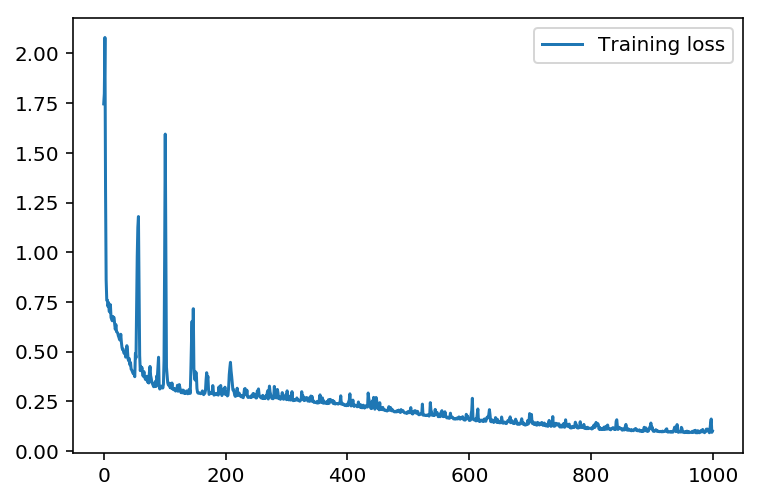

In [12]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

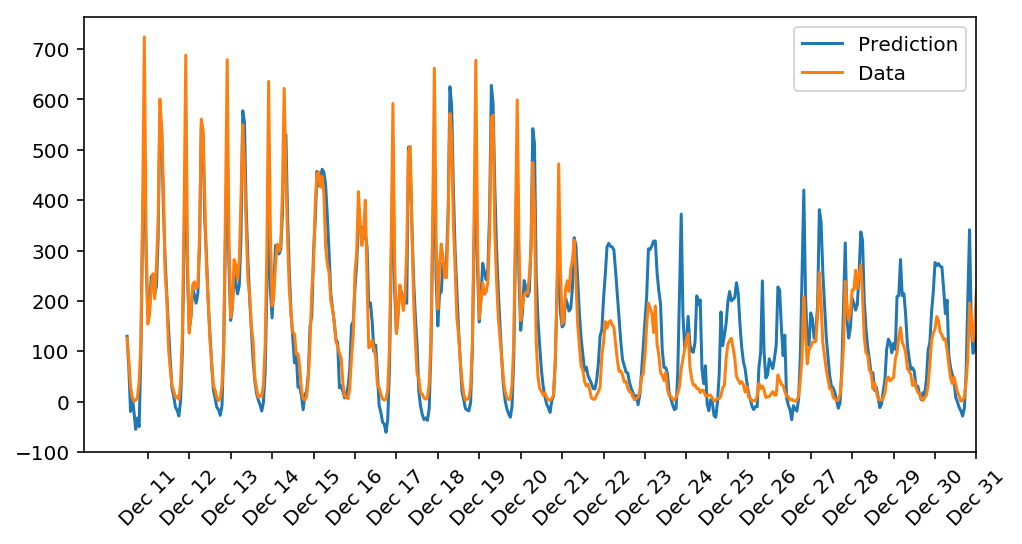

In [13]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)